In [1]:
# Load CLIP model and process first image
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

print(f"✓ CLIP model loaded: {model_name}")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ CLIP model loaded: openai/clip-vit-base-patch32


In [2]:
import os

photos_dir = os.path.expanduser("~/Desktop/photos")
photo_files = []
if os.path.isdir(photos_dir):
    # List only files (not directories), and filter for common image extensions
    valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".webp")
    photo_files = [
        os.path.join(photos_dir, f)
        for f in os.listdir(photos_dir)
        if os.path.isfile(os.path.join(photos_dir, f)) and f.lower().endswith(valid_exts)
    ]
    print(f"Found {len(photo_files)} photo(s) in {photos_dir}")
else:
    print(f"Directory not found: {photos_dir}")

Found 3383 photo(s) in /Users/sinanozdemir/Desktop/photos


In [3]:
# Image RAG System with ChromaDB and CLIP
import chromadb
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Dict, Any
import json

class ImageRAGSystem:
    def __init__(self, chroma_db_path="./image_chromadb", collection_name="image_embeddings"):
        self.chroma_db_path = chroma_db_path
        self.collection_name = collection_name
        
        # Use existing CLIP model from previous cell
        print("🔄 Loading CLIP model...")
        self.model_name = "openai/clip-vit-base-patch32"
        self.model = CLIPModel.from_pretrained(self.model_name)
        self.processor = CLIPProcessor.from_pretrained(self.model_name)
        print("✅ CLIP model loaded")
    
        # Initialize ChromaDB
        print("🔄 Initializing ChromaDB...")
        self.client = chromadb.PersistentClient(path=chroma_db_path)
        
        # Create or get collection
        try:
            self.collection = self.client.get_collection(name=collection_name)
            print(f"✅ Found existing collection: {collection_name}")
        except:
            self.collection = self.client.create_collection(
                name=collection_name,
                metadata={"hnsw:space": "cosine"}
            )
            print(f"✅ Created new collection: {collection_name}")
    
    def get_image_embedding(self, image_path: str) -> np.ndarray:
        """Get CLIP embedding for a single image"""
        try:
            image = Image.open(image_path)
            inputs = self.processor(images=image, return_tensors="pt")
            
            with torch.no_grad():
                image_features = self.model.get_image_features(**inputs)
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
            return image_features.cpu().numpy().flatten()
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None
    
    def get_text_embedding(self, text: str) -> np.ndarray:
        """Get CLIP embedding for text query"""
        inputs = self.processor(text=[text], return_tensors="pt", padding=True)
        
        with torch.no_grad():
            text_features = self.model.get_text_features(**inputs)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        return text_features.cpu().numpy().flatten()
    
    def add_images(self, image_paths: List[str], batch_size: int = 16):
        """Add images to ChromaDB with their embeddings"""
        print(f"🔄 Processing {len(image_paths)} images...")
        
        # Check if images already exist
        existing_count = self.collection.count()
        print(f"⚠️  Collection already has {existing_count} images")
        # Get all image paths already in the collection to avoid duplicates
        existing_metadatas = []
        if existing_count > 0:
            # ChromaDB returns metadatas in batches, so we need to paginate if large
            batch_size_meta = 1000
            for offset in range(0, existing_count, batch_size_meta):
                res = self.collection.get(
                    include=["metadatas"],
                    limit=batch_size_meta,
                    offset=offset
                )
                if "metadatas" in res and res["metadatas"]:
                    existing_metadatas.extend(res["metadatas"])
        existing_paths = set(meta["path"] for meta in existing_metadatas if "path" in meta)
        print(f"🔄 Skipping {len(set(image_paths) & set(existing_paths))} duplicate images")
        image_paths = [path for path in image_paths if path not in existing_paths]
        
        
        # Process images in batches
        for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing batches"):
            batch_paths = image_paths[i:i + batch_size]
            batch_embeddings = []
            batch_ids = []
            batch_metadata = []
            
            for image_path in batch_paths:
                embedding = self.get_image_embedding(image_path)
                if embedding is not None:
                    batch_embeddings.append(embedding.tolist())
                    batch_ids.append(os.path.basename(image_path))
                    batch_metadata.append({
                        "path": image_path,
                        "filename": os.path.basename(image_path),
                        "size": os.path.getsize(image_path)
                    })
            
            # Add to ChromaDB
            if batch_embeddings:
                self.collection.add(
                    embeddings=batch_embeddings,
                    ids=batch_ids,
                    metadatas=batch_metadata
                )
        
        print(f"✅ Added {len(image_paths)} images to ChromaDB")
        print(f"Total images in collection: {self.collection.count()}")
        return self.collection.count()
    
    def query_images(self, query: str, k: int = 5, guidance: str = None, text_weight: float = 0.7, guidance_weight: float = 0.3) -> List[Dict[str, Any]]:
        """
        Query for similar images using natural language.
        If guidance is provided, combine text similarity and guidance image similarity with weighted scoring.
        
        Args:
            query: Text query for semantic search
            k: Number of results to return
            guidance: Path to guidance image for visual similarity
            text_weight: Weight for text similarity (default 0.7)
            guidance_weight: Weight for guidance similarity (default 0.3)
        """
        print(f"🔍 Searching for: '{query}'")
        
        if guidance is not None:
            print(f"🧭 Using guidance image: {guidance}")
            print(f"📊 Weights - Text: {text_weight}, Guidance: {guidance_weight}")
            
            # Get embeddings
            guidance_embedding = self.get_image_embedding(guidance)
            query_embedding = self.get_text_embedding(query)
            
            if guidance_embedding is None:
                print("⚠️ Could not compute embedding for guidance image. Falling back to text-only search.")
                guidance = None
            else:
                # Get ALL items in the collection with their embeddings
                print("🔄 Computing combined similarity scores for all images...")
                
                # Get all items (might need to paginate for very large collections)
                all_count = self.collection.count()
                batch_size = 1000  # Process in batches to avoid memory issues
                
                all_similarities = []
                
                for offset in range(0, all_count, batch_size):
                    batch_items = self.collection.get(
                        include=['embeddings', 'metadatas'],
                        limit=batch_size,
                        offset=offset
                    )
                    
                    for i, embedding in enumerate(batch_items['embeddings']):
                        # Convert to numpy arrays
                        item_embedding = np.array(embedding)
                        query_emb = np.array(query_embedding)
                        guidance_emb = np.array(guidance_embedding)
                        
                        # Compute cosine similarities
                        text_similarity = np.dot(query_emb, item_embedding) / (np.linalg.norm(query_emb) * np.linalg.norm(item_embedding))
                        guidance_similarity = np.dot(guidance_emb, item_embedding) / (np.linalg.norm(guidance_emb) * np.linalg.norm(item_embedding))
                        
                        # Combined score with weights
                        combined_score = (text_weight * text_similarity) + (guidance_weight * guidance_similarity)
                        combined_distance = 1 - combined_score
                        
                        all_similarities.append({
                            'id': batch_items['ids'][i],
                            'path': batch_items['metadatas'][i]['path'],
                            'filename': batch_items['metadatas'][i]['filename'],
                            'distance': combined_distance,
                            'similarity': combined_score,
                            'text_similarity': text_similarity,
                            'guidance_similarity': guidance_similarity
                        })
                
                # Sort by combined similarity (descending) and take top k
                all_similarities.sort(key=lambda x: x['similarity'], reverse=True)
                return all_similarities[:k]

        # If no guidance or fallback - regular text search
        print("🔍 Performing text-only search...")
        query_embedding = self.get_text_embedding(query)
        results = self.collection.query(
            query_embeddings=[query_embedding.tolist()],
            n_results=k
        )
        
        # Format results
        formatted_results = []
        for i in range(len(results['ids'][0])):
            result = {
                'id': results['ids'][0][i],
                'path': results['metadatas'][0][i]['path'],
                'filename': results['metadatas'][0][i]['filename'],
                'distance': results['distances'][0][i],
                'similarity': 1 - results['distances'][0][i],
                'text_similarity': 1 - results['distances'][0][i],  # Same as similarity for text-only
                'guidance_similarity': None
            }
            formatted_results.append(result)
        return formatted_results
    
    def display_results(self, results: List[Dict[str, Any]], query: str):
        """Display query results with images"""
        if not results:
            print("No results found!")
            return
        
        # Create subplot grid
        n_results = len(results)
        cols = min(3, n_results)
        rows = (n_results + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        if rows == 1:
            axes = [axes] if cols == 1 else axes
        else:
            axes = axes.flatten()
        
        fig.suptitle(f"Query: '{query}' - Top {n_results} Results", fontsize=16)
        
        for i, result in enumerate(results):
            try:
                # Load and display image
                image = Image.open(result['path'])
                axes[i].imshow(image)
                
                # Create title with breakdown if guidance was used
                if result.get('guidance_similarity') is not None:
                    title = f"{result['filename']}\nCombined: {result['similarity']:.3f}\n(Text: {result['text_similarity']:.3f}, Visual: {result['guidance_similarity']:.3f})"
                else:
                    title = f"{result['filename']}\nSimilarity: {result['similarity']:.3f}"
                
                axes[i].set_title(title, fontsize=10)
                axes[i].axis('off')
            except Exception as e:
                axes[i].text(0.5, 0.5, f"Error loading image:\n{str(e)}", 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f"{result['filename']}\nError")
        
        # Hide unused subplots
        for i in range(len(results), len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print results summary
        print(f"\nResults for '{query}':")
        for i, result in enumerate(results, 1):
            if result.get('guidance_similarity') is not None:
                print(f"{i}. {result['filename']} (combined: {result['similarity']:.3f}, text: {result['text_similarity']:.3f}, visual: {result['guidance_similarity']:.3f})")
            else:
                print(f"{i}. {result['filename']} (similarity: {result['similarity']:.3f})")
    
    def get_collection_stats(self):
        """Get statistics about the collection"""
        count = self.collection.count()
        print(f"📊 Collection Statistics:")
        print(f"   Name: {self.collection_name}")
        print(f"   Total images: {count}")
        print(f"   Database path: {self.chroma_db_path}")
        
        if count > 0:
            # Get a sample to show what's in the collection
            sample = self.collection.get(limit=3)
            print(f"   Sample images: {sample['ids']}")
        
        return count

In [4]:
# Initialize the RAG system
print("🚀 Initializing Image RAG System...")
rag_system = ImageRAGSystem()
print("✅ Image RAG System ready!")


🚀 Initializing Image RAG System...
🔄 Loading CLIP model...
✅ CLIP model loaded
🔄 Initializing ChromaDB...
✅ Found existing collection: image_embeddings
✅ Image RAG System ready!


In [5]:
# Example setup: show collection stats and (optionally) add images to the collection

# Show current collection stats
rag_system.get_collection_stats()

# Example: Add images to the collection
rag_system.add_images(photo_files)


📊 Collection Statistics:
   Name: image_embeddings
   Total images: 3383
   Database path: ./image_chromadb
   Sample images: ['IMG_2373.png', 'IMG_0564.png', 'IMG_0202.png']
🔄 Processing 3383 images...
⚠️  Collection already has 3383 images
🔄 Skipping 3383 duplicate images


Processing batches: 0it [00:00, ?it/s]

✅ Added 0 images to ChromaDB
Total images in collection: 3383


3383

In [6]:
[i for i in photo_files if "image000007.png" in i]

['/Users/sinanozdemir/Desktop/photos/image000007.png']

🔍 Searching for: 'sleeping cat'
🔍 Performing text-only search...


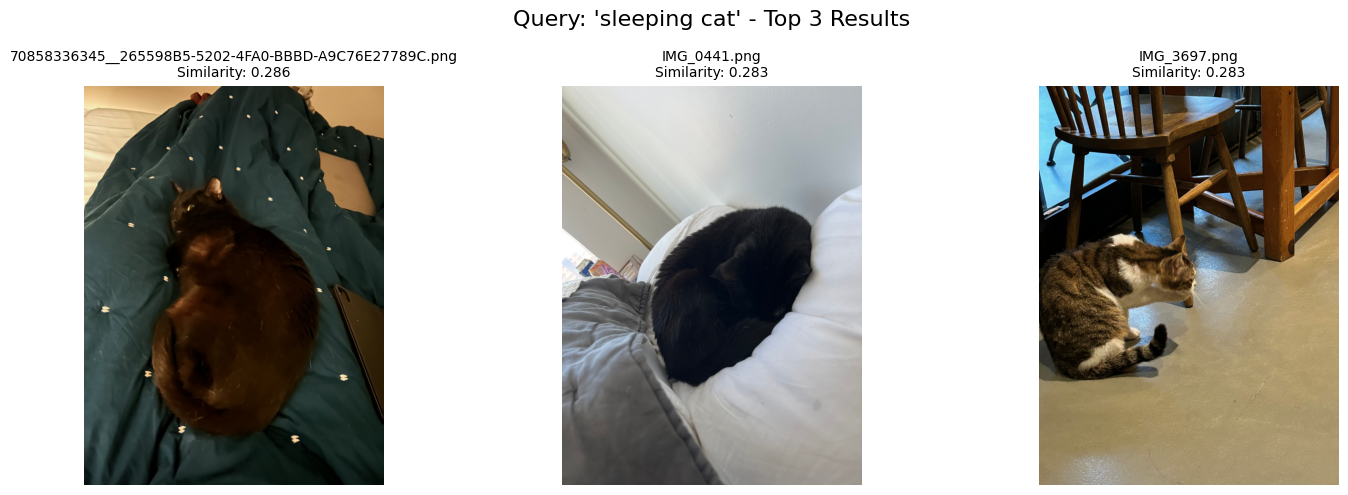


Results for 'sleeping cat':
1. 70858336345__265598B5-5202-4FA0-BBBD-A9C76E27789C.png (similarity: 0.286)
2. IMG_0441.png (similarity: 0.283)
3. IMG_3697.png (similarity: 0.283)


In [7]:
query = "sleeping cat"
results = rag_system.query_images(query, k=3, guidance=None)
rag_system.display_results(results, query)

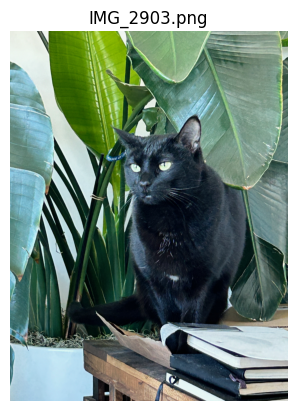

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

guided_img_path = '/Users/sinanozdemir/Desktop/photos/IMG_2903.png'
img = Image.open(guided_img_path)
plt.imshow(img)
plt.axis('off')
plt.title(guided_img_path.split('/')[-1])
plt.show()


🔍 Searching for: 'sleeping cat'
🧭 Using guidance image: /Users/sinanozdemir/Desktop/photos/IMG_2903.png
📊 Weights - Text: 0.9, Guidance: 0.1
🔄 Computing combined similarity scores for all images...


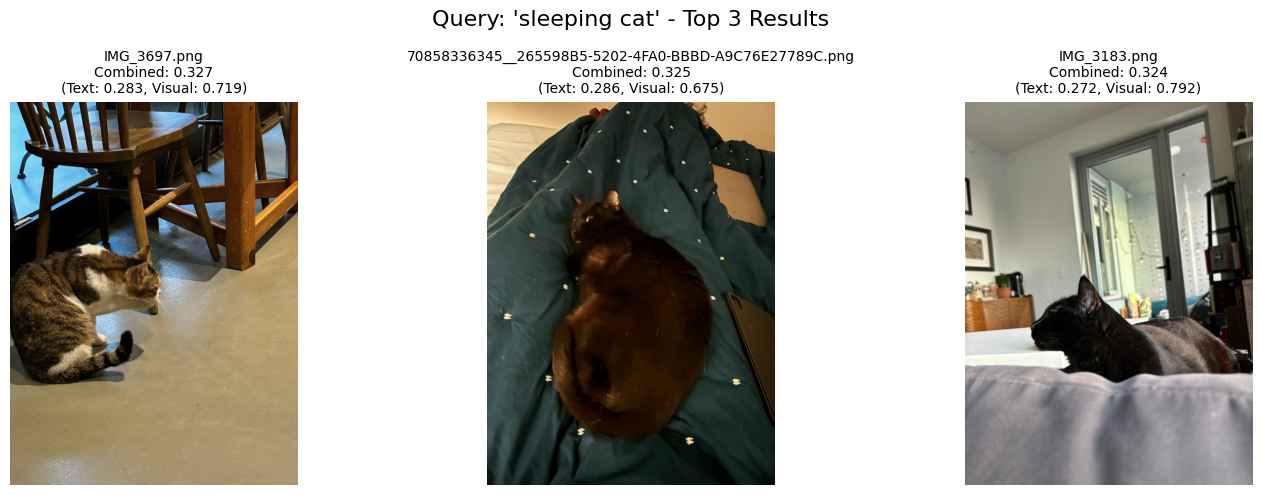


Results for 'sleeping cat':
1. IMG_3697.png (combined: 0.327, text: 0.283, visual: 0.719)
2. 70858336345__265598B5-5202-4FA0-BBBD-A9C76E27789C.png (combined: 0.325, text: 0.286, visual: 0.675)
3. IMG_3183.png (combined: 0.324, text: 0.272, visual: 0.792)


In [9]:
guided_results = rag_system.query_images(
    query, 
    k=3, 
    guidance=guided_img_path,
    text_weight=0.9,
    guidance_weight=0.1
)
rag_system.display_results(guided_results, query)

# ViLT for Re-ranking

In [10]:
from transformers import ViltProcessor, ViltForImageAndTextRetrieval, ViltModel
import requests
from PIL import Image

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
texts = ["An image of two cats chilling on a couch", "A football player scoring a goal"]

VILT_MODEL = 'dandelin/vilt-b32-finetuned-coco'
VILT_MODEL = 'dandelin/vilt-b32-finetuned-nlvr2'
# VILT_MODEL = 'dandelin/vilt-b32-mlm'
vilt_processor = ViltProcessor.from_pretrained(VILT_MODEL)
vilt_model = ViltForImageAndTextRetrieval.from_pretrained(VILT_MODEL)

Some weights of ViltForImageAndTextRetrieval were not initialized from the model checkpoint at dandelin/vilt-b32-finetuned-nlvr2 and are newly initialized: ['rank_output.bias', 'rank_output.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# forward pass
scores = dict()
for text in texts:
    encoding = vilt_processor(image, text, return_tensors="pt")
    outputs = vilt_model(**encoding)
    scores[text] = outputs.logits[0, :].item()

for text, score in scores.items():
    print(f"{text}: {score}")

An image of two cats chilling on a couch: 0.038224607706069946
A football player scoring a goal: -0.13596026599407196


In [25]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any
import requests

class RerankState(TypedDict):
    k: int
    query: str
    clip_results: List[Dict[str, Any]]
    reranked_results: List[Dict[str, Any]]

def fetch_clip_images(state: RerankState) -> RerankState:
    # Use the rag_system to get k images for the query using CLIP
    results = rag_system.query_images(
        state["query"],
        k=state["k"],
    )
    state["clip_results"] = results
    return state

def rerank_with_vilt(state: RerankState) -> RerankState:
    scores = []
    for result in state["clip_results"]:
        print(f'Ranking {result}')
        candidate_img_path = result['path']
        candidate_img = Image.open(candidate_img_path)
        encoding = vilt_processor(candidate_img, state["query"], return_tensors="pt")
        outputs = vilt_model(**encoding)
        score = outputs.logits[0, :].item()
        scores.append((result['path'], state['query'], score))
    # Sort by score descending
    scores.sort(key=lambda x: x[2], reverse=True)
    # Prepare reranked results
    state["reranked_results"] = [{"image_path": path, "caption": caption, "score": score} for path, caption, score in scores]
    return state

def output_results(state: RerankState) -> RerankState:
    print("Reranked Results:")
    for i, item in enumerate(state["reranked_results"]):
        print(f"{i+1}. {item['image_path']} (score: {item['score']:.4f}) - {item['caption']}")
    return state

# Build the workflow
graph = StateGraph(RerankState)
graph.add_node("fetch_clip_images", fetch_clip_images)
graph.add_node("rerank_with_vilt", rerank_with_vilt)
graph.add_node("output_results", output_results)

graph.set_entry_point("fetch_clip_images")
graph.add_edge("fetch_clip_images", "rerank_with_vilt")
graph.add_edge("rerank_with_vilt", "output_results")
graph.add_edge("output_results", END)

workflow = graph.compile()


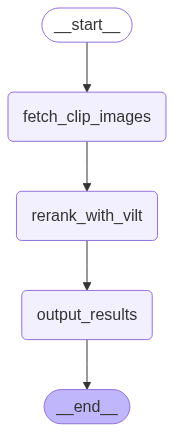

In [26]:
workflow

In [49]:
# Example usage:
state = {
    "k": 10,
    "query": "A cat or a dog sitting by a door"
}
results = workflow.invoke(state)


🔍 Searching for: 'A cat or a dog sitting by a door'
🔍 Performing text-only search...
Ranking {'id': 'IMG_2102.png', 'path': '/Users/sinanozdemir/Desktop/photos/IMG_2102.png', 'filename': 'IMG_2102.png', 'distance': 0.6812320947647095, 'similarity': 0.3187679052352905, 'text_similarity': 0.3187679052352905, 'guidance_similarity': None}
Ranking {'id': 'IMG_1245.png', 'path': '/Users/sinanozdemir/Desktop/photos/IMG_1245.png', 'filename': 'IMG_1245.png', 'distance': 0.6845965385437012, 'similarity': 0.31540346145629883, 'text_similarity': 0.31540346145629883, 'guidance_similarity': None}
Ranking {'id': 'IMG_2143.png', 'path': '/Users/sinanozdemir/Desktop/photos/IMG_2143.png', 'filename': 'IMG_2143.png', 'distance': 0.6904345154762268, 'similarity': 0.3095654845237732, 'text_similarity': 0.3095654845237732, 'guidance_similarity': None}
Ranking {'id': 'IMG_2144.png', 'path': '/Users/sinanozdemir/Desktop/photos/IMG_2144.png', 'filename': 'IMG_2144.png', 'distance': 0.7001392245292664, 'simila

Image,Filename,CLIP Similarity,ViLT Score
,IMG_2102.png,0.3188,-0.2488
,IMG_1245.png,0.3154,-0.1050
,IMG_2143.png,0.3096,-0.2280
,IMG_2144.png,0.2999,-0.2136
,IMG_1708.png,0.2907,-0.1828
,IMG_0642.png,0.2881,-0.0633
,IMG_2816.png,0.2865,-0.0361
,69620787450__F3AFCF0E-4BD0-47EF-90F2-5E463BF7C008.png,0.2861,-0.2288
,IMG_2763.png,0.2861,0.0112
,IMG_2756.png,0.2858,-0.0852

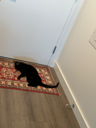
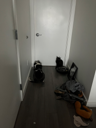
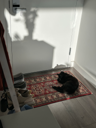
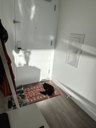
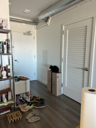
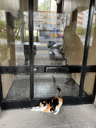
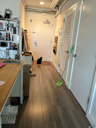
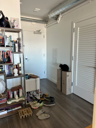
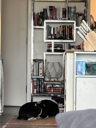
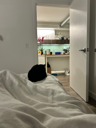
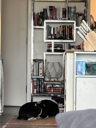
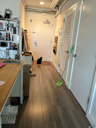
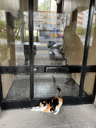
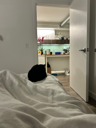
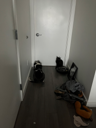
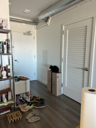
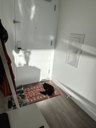
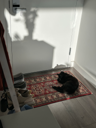
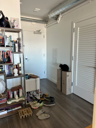
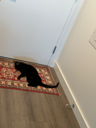

In [54]:
from IPython.display import display, HTML
from PIL import Image
import base64
import io
import os

def image_to_base64(img_path, max_size=(128, 128)):
    try:
        img = Image.open(img_path)
        img.thumbnail(max_size)
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_b64 = base64.b64encode(buffered.getvalue()).decode()
        return f'<img src="data:image/png;base64,{img_b64}" style="max-width:128px;max-height:128px;"/>'
    except Exception as e:
        return "<i>Image not found</i>"

def pretty_print_results_side_by_side(results):
    # Build a mapping from filename to CLIP similarity and path
    clip_sim_map = {}
    clip_path_map = {}
    for c in results.get("clip_results", []):
        clip_sim_map[c.get("filename", "")] = c.get("similarity", None)
        clip_path_map[c.get("filename", "")] = c.get("path", "")

    # Build a mapping from filename to rerank score and image_path
    rerank_score_map = {}
    rerank_path_map = {}
    for item in results.get("reranked_results", []):
        image_info = item.get("image_path", {})
        if isinstance(image_info, dict):
            filename = image_info.get("filename", "") or image_info.get("id", "")
            img_path = image_info.get("filepath") or image_info.get("path", "")
        else:
            img_path = image_info
            filename = os.path.basename(img_path) if img_path else ""
        rerank_score = item.get("score", 0.0)
        rerank_score_map[filename] = rerank_score
        rerank_path_map[filename] = img_path

    # Prepare sorted lists
    clip_sorted = []
    for c in results.get("clip_results", []):
        filename = c.get("filename", "")
        sim = c.get("similarity", None)
        img_path = c.get("path", "")
        rerank_score = rerank_score_map.get(filename, None)
        clip_sorted.append({
            "filename": filename,
            "img_path": img_path,
            "clip_sim": sim,
            "rerank_score": rerank_score
        })
    clip_sorted = sorted(clip_sorted, key=lambda x: x["clip_sim"] if x["clip_sim"] is not None else -1, reverse=True)

    rerank_sorted = []
    for item in results.get("reranked_results", []):
        image_info = item.get("image_path", {})
        if isinstance(image_info, dict):
            filename = image_info.get("filename", "") or image_info.get("id", "")
            img_path = image_info.get("filepath") or image_info.get("path", "")
        else:
            img_path = image_info
            filename = os.path.basename(img_path) if img_path else ""
        clip_sim = clip_sim_map.get(filename, None)
        rerank_score = item.get("score", 0.0)
        rerank_sorted.append({
            "filename": filename,
            "img_path": img_path,
            "clip_sim": clip_sim,
            "rerank_score": rerank_score
        })
    rerank_sorted = sorted(rerank_sorted, key=lambda x: x["rerank_score"] if x["rerank_score"] is not None else -1, reverse=True)

    # Top 3 for highlighting
    top3_clip = set([x["filename"] for x in clip_sorted[:3]])
    top3_rerank = set([x["filename"] for x in rerank_sorted[:3]])

    html = f"<p style='font-size:2em;'><b>Query: {results.get('query', '')}</b></p>"

    html += """
    <div style="display:flex;gap:32px;">
      <div style="flex:1;">
        <h3>Sorted by CLIP Similarity</h3>
        <table style='border-collapse:collapse;min-width:350px;'>
          <tr>
            <th>Image</th>
            <th>Filename</th>
            <th>CLIP Similarity</th>
            <th>ViLT Score</th>
          </tr>
    """
    for item in clip_sorted:
        img_html = image_to_base64(item["img_path"]) if item["img_path"] else "<i>No image</i>"
        filename = item["filename"]
        clip_sim = item["clip_sim"]
        rerank_score = item["rerank_score"]

        html += "<tr>"
        html += f"<td>{img_html}</td>"
        html += f"<td><b>{filename}</b></td>"

        # Highlight top 3 in CLIP similarity
        if clip_sim is not None:
            if filename in top3_clip:
                html += f"<td><b style='color:#fff;background:#007bff;padding:2px 6px;border-radius:4px'>{clip_sim:.4f}</b></td>"
            else:
                html += f"<td><b>{clip_sim:.4f}</b></td>"
        else:
            html += "<td><b>N/A</b></td>"

        # Highlight top 3 in rerank score
        if rerank_score is not None:
            if filename in top3_rerank:
                html += f"<td><b style='color:#fff;background:#28a745;padding:2px 6px;border-radius:4px'>{rerank_score:.4f}</b></td>"
            else:
                html += f"<td><b>{rerank_score:.4f}</b></td>"
        else:
            html += "<td><b>N/A</b></td>"

        html += "</tr>"
    html += "</table></div>"

    html += """
      <div style="flex:1;">
        <h3>Sorted by ViLT Rerank Score</h3>
        <table style='border-collapse:collapse;min-width:350px;'>
          <tr>
            <th>Image</th>
            <th>Filename</th>
            <th>CLIP Similarity</th>
            <th>ViLT Score</th>
          </tr>
    """
    for item in rerank_sorted:
        img_html = image_to_base64(item["img_path"]) if item["img_path"] else "<i>No image</i>"
        filename = item["filename"]
        clip_sim = item["clip_sim"]
        rerank_score = item["rerank_score"]

        html += "<tr>"
        html += f"<td>{img_html}</td>"
        html += f"<td><b>{filename}</b></td>"

        # Highlight top 3 in CLIP similarity
        if clip_sim is not None:
            if filename in top3_clip:
                html += f"<td><b style='color:#fff;background:#007bff;padding:2px 6px;border-radius:4px'>{clip_sim:.4f}</b></td>"
            else:
                html += f"<td><b>{clip_sim:.4f}</b></td>"
        else:
            html += "<td><b>N/A</b></td>"

        # Highlight top 3 in rerank score
        if rerank_score is not None:
            if filename in top3_rerank:
                html += f"<td><b style='color:#fff;background:#28a745;padding:2px 6px;border-radius:4px'>{rerank_score:.4f}</b></td>"
            else:
                html += f"<td><b>{rerank_score:.4f}</b></td>"
        else:
            html += "<td><b>N/A</b></td>"

        html += "</tr>"
    html += "</table></div></div>"

    display(HTML(html))

pretty_print_results_side_by_side(results)

In [16]:
assert 1 == 2

AssertionError: 

# BONUS: Using Moondream to get a third score

In [ ]:
import moondream as md
from PIL import Image

# Initialize for Moondream Cloud
cloud_model = md.vl(api_key="your-moondream-api-key-here")


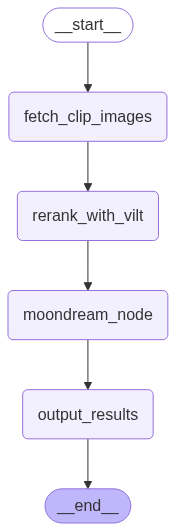

In [30]:
import langgraph

# Extend RerankState to include Moondream fields
from typing import TypedDict, List, Dict, Any, Optional

class ExtendedRerankState(TypedDict, total=False):
    k: int
    query: str
    clip_results: List[Dict[str, Any]]
    reranked_results: List[Dict[str, Any]]
    moondream_results: List[Dict[str, Any]]

def moondream_node(state: ExtendedRerankState) -> ExtendedRerankState:
    """
    Node for querying the Moondream cloud model with an image and a question.
    Expects state to have 'image' and 'question' keys.
    Returns updated state with 'moondream_results' (a list of dicts).
    """
    query = state.get("query")
    # Ensure moondream_results is initialized
    if "moondream_results" not in state:
        state["moondream_results"] = []
    for image_dict in state.get("clip_results", []):  # assumes CLIP has already run
        image_path = image_dict.get("path")
        if image_path is None:
            print("No path found for image")
            continue  # skip if no path
        try:
            img = Image.open(image_path)
            answer = cloud_model.query(img, f"Does this image match the description: '{query}'? Answe YES or NO")["answer"]
        except Exception as e:
            answer = f"Error: {e}"
        state["moondream_results"].append({"image": image_dict, "question": query, "answer": answer})
    return state

# Rebuild the workflow to include the Moondream node
moondream_graph = langgraph.graph.StateGraph(ExtendedRerankState)
moondream_graph.add_node("fetch_clip_images", fetch_clip_images)
moondream_graph.add_node("rerank_with_vilt", rerank_with_vilt)
moondream_graph.add_node("output_results", output_results)
moondream_graph.add_node("moondream_node", moondream_node)

moondream_graph.set_entry_point("fetch_clip_images")
moondream_graph.add_edge("fetch_clip_images", "rerank_with_vilt")
moondream_graph.add_edge("rerank_with_vilt", "moondream_node")
moondream_graph.add_edge("moondream_node", "output_results")
moondream_graph.add_edge("output_results", langgraph.graph.END)

moondream_workflow = moondream_graph.compile()
moondream_workflow

In [32]:
# example usage
state = {
    "k": 10,
    "query": "Black cat or a dog sitting and waiting by a door for someone to come home"
}
results = moondream_workflow.invoke(state)

🔍 Searching for: 'Black cat or a dog sitting and waiting by a door for someone to come home'
🔍 Performing text-only search...
Ranking {'id': 'IMG_2102.png', 'path': '/Users/sinanozdemir/Desktop/photos/IMG_2102.png', 'filename': 'IMG_2102.png', 'distance': 0.6732208728790283, 'similarity': 0.3267791271209717, 'text_similarity': 0.3267791271209717, 'guidance_similarity': None}
Ranking {'id': 'IMG_2143.png', 'path': '/Users/sinanozdemir/Desktop/photos/IMG_2143.png', 'filename': 'IMG_2143.png', 'distance': 0.6878294348716736, 'similarity': 0.3121705651283264, 'text_similarity': 0.3121705651283264, 'guidance_similarity': None}
Ranking {'id': 'IMG_1245.png', 'path': '/Users/sinanozdemir/Desktop/photos/IMG_1245.png', 'filename': 'IMG_1245.png', 'distance': 0.6961382627487183, 'similarity': 0.30386173725128174, 'text_similarity': 0.30386173725128174, 'guidance_similarity': None}
Ranking {'id': 'IMG_2144.png', 'path': '/Users/sinanozdemir/Desktop/photos/IMG_2144.png', 'filename': 'IMG_2144.png'

In [35]:
results

{'k': 10,
 'query': 'Black cat or a dog sitting and waiting by a door for someone to come home',
 'clip_results': [{'id': 'IMG_2102.png',
   'path': '/Users/sinanozdemir/Desktop/photos/IMG_2102.png',
   'filename': 'IMG_2102.png',
   'distance': 0.6732208728790283,
   'similarity': 0.3267791271209717,
   'text_similarity': 0.3267791271209717,
   'guidance_similarity': None},
  {'id': 'IMG_2143.png',
   'path': '/Users/sinanozdemir/Desktop/photos/IMG_2143.png',
   'filename': 'IMG_2143.png',
   'distance': 0.6878294348716736,
   'similarity': 0.3121705651283264,
   'text_similarity': 0.3121705651283264,
   'guidance_similarity': None},
  {'id': 'IMG_1245.png',
   'path': '/Users/sinanozdemir/Desktop/photos/IMG_1245.png',
   'filename': 'IMG_1245.png',
   'distance': 0.6961382627487183,
   'similarity': 0.30386173725128174,
   'text_similarity': 0.30386173725128174,
   'guidance_similarity': None},
  {'id': 'IMG_2144.png',
   'path': '/Users/sinanozdemir/Desktop/photos/IMG_2144.png',
   

In [39]:
# the description has two conditions: (black cat OR dog) AND (sitting AND waiting)

# CLIP was worse than rerank in this case (the ones there euclid is lying down is NOT her sitting but moondream still said YES)

# CLIP's semantic similarity is not good enough to encode these semantics but the attention mechanism jointly modeling text and images in VilT can pick up that slack where VQA models like Moondream can also make those reasoning steps but only if prompted to provide a chain of thought reasoning. Even it can be wrong though or at least subjective (like it thinking the cat laying there is it sitting and waiting)

In [ ]:
from IPython.display import display, HTML
from PIL import Image
import base64
import io

def image_to_base64(img_path, max_size=(128, 128)):
    try:
        img = Image.open(img_path)
        img.thumbnail(max_size)
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_b64 = base64.b64encode(buffered.getvalue()).decode()
        return f'<img src="data:image/png;base64,{img_b64}" style="max-width:256px;max-height:256px;"/>'
    except Exception as e:
        return "<i>Image not found</i>"

def safe_get(d, key, default=""):
    """Safely get key from dict, else return default. If d is not a dict, return default."""
    if isinstance(d, dict):
        return d.get(key, default)
    return default

def pretty_print_results(results):
    html = "<h2>Query: " + results.get('query', '') + "</h2>"
    
    html += "<table style='border-collapse:collapse;'>"
    html += "<tr><th>Image</th><th>CLIP Similarity</th><th>Rerank Score</th><th>Moondream Answer to<br>Does this image match the description:</th></tr>"

    # Build a mapping from image id/filename to CLIP similarity
    clip_sim_map = {}
    for c in results.get("clip_results", []):
        # Use both filename and id as keys for robustness
        for key in [safe_get(c, "filename", ""), safe_get(c, "id", "")]:
            if key:
                clip_sim_map[key] = c.get("similarity", None)

    # Build a mapping from image id/filename to Moondream answer
    moondream_map = {}
    for m in results.get("moondream_results", []):
        image_info = m.get("image", {})
        for key in [safe_get(image_info, "filename", ""), safe_get(image_info, "id", "")]:
            if key:
                moondream_map[key] = m.get("answer", "N/A")

    # Prepare lists for top 3 CLIP and top 3 rerank
    clip_scores = []
    for c in results.get("clip_results", []):
        for key in [safe_get(c, "filename", ""), safe_get(c, "id", "")]:
            sim = c.get("similarity", None)
            if key and sim is not None:
                clip_scores.append((key, sim))
    # Remove duplicates, keep highest sim for each key
    clip_scores_dict = {}
    for key, sim in clip_scores:
        if key not in clip_scores_dict or sim > clip_scores_dict[key]:
            clip_scores_dict[key] = sim
    clip_scores = list(clip_scores_dict.items())
    clip_scores.sort(key=lambda x: x[1], reverse=True)
    top3_clip = [x[0] for x in clip_scores[:3]]

    rerank_scores = []
    for item in results.get("reranked_results", []):
        image_info = item.get("image_path", {})
        if isinstance(image_info, dict):
            keys = [safe_get(image_info, "filename", ""), safe_get(image_info, "id", "")]
        else:
            keys = [""]
        rerank_score = item.get("score", 0.0)
        for key in keys:
            if key:
                rerank_scores.append((key, rerank_score))
    # Remove duplicates, keep highest score for each key
    rerank_scores_dict = {}
    for key, score in rerank_scores:
        if key not in rerank_scores_dict or score > rerank_scores_dict[key]:
            rerank_scores_dict[key] = score
    rerank_scores = list(rerank_scores_dict.items())
    rerank_scores.sort(key=lambda x: x[1], reverse=True)
    top3_rerank = [x[0] for x in rerank_scores[:3]]

    # Calculate accuracy for CLIP and rerank (top-1 and top-3)
    def accuracy(top_keys):
        if not top_keys:
            return 0.0
        yes_count = 0
        total = 0
        for key in top_keys:
            ans = moondream_map.get(key, "N/A")
            if isinstance(ans, str) and ans.strip().upper().startswith("YES"):
                yes_count += 1
            total += 1
        return yes_count / total if total > 0 else 0.0

    clip_top1_acc = accuracy(top3_clip[:1])
    clip_top3_acc = accuracy(top3_clip)
    rerank_top1_acc = accuracy(top3_rerank[:1])
    rerank_top3_acc = accuracy(top3_rerank)

    # Show accuracy summary
    html += "<br><div style='margin:1em 0;padding:1em;background:#f8f9fa;border-radius:8px;'>"
    html += "<h3>Accuracy (Moondream 'YES' in Top Results):</h3>"
    html += "<ul style='font-size:1.2em;'>"
    html += f"<li><b>CLIP Top-1:</b> {clip_top1_acc*100:.1f}%</li>"
    html += f"<li><b>CLIP Top-3:</b> {clip_top3_acc*100:.1f}%</li>"
    html += f"<li><b>Rerank Top-1:</b> {rerank_top1_acc*100:.1f}%</li>"
    html += f"<li><b>Rerank Top-3:</b> {rerank_top3_acc*100:.1f}%</li>"
    html += "</ul></div>"

    for item in results.get("reranked_results", []):
        image_info = item.get("image_path", {})
        if isinstance(image_info, dict):
            # Try both filename and id for key lookup
            keys = [safe_get(image_info, "filename", ""), safe_get(image_info, "id", "")]
            img_path = image_info.get("filepath") or image_info.get("path", "")
            # Prefer filename, then id
            key = next((k for k in keys if k), "")
            clip_sim = clip_sim_map.get(key, None)
        else:
            img_path = None
            key = ""
            clip_sim = None
        rerank_score = item.get("score", 0.0)

        img_html = image_to_base64(img_path) if img_path else "<i>No image</i>"

        html += "<tr>"
        html += f"<td>{img_html}</td>"

        # Highlight top 3 in CLIP similarity
        if clip_sim is not None:
            if key in top3_clip:
                html += f"<td><b style='color:#fff;background:#007bff;padding:2px 6px;border-radius:4px'>{clip_sim:.4f}</b></td>"
            else:
                html += f"<td><b>{clip_sim:.4f}</b></td>"
        else:
            html += "<td><b>N/A</b></td>"

        # Highlight top 3 in rerank score
        if key in top3_rerank:
            html += f"<td><b style='color:#fff;background:#28a745;padding:2px 6px;border-radius:4px'>{rerank_score:.4f}</b></td>"
        else:
            html += f"<td><b>{rerank_score:.4f}</b></td>"

        # Moondream answer for this image
        # Try both filename and id for answer lookup
        moondream_answer = None
        if isinstance(image_info, dict):
            for k in [safe_get(image_info, "filename", ""), safe_get(image_info, "id", "")]:
                if k and k in moondream_map:
                    moondream_answer = moondream_map[k]
                    break
        if moondream_answer is None:
            moondream_answer = "N/A"
        html += f"<td><b>{moondream_answer}</b></td>"

        html += "</tr>"

    html += "</table>"
    display(HTML(html))

pretty_print_results(results)

Image,CLIP Similarity,Rerank Score,Moondream Answer toDoes this image match the description:
No image,N/A,0.1072,N/A
No image,N/A,-0.0207,N/A
No image,N/A,-0.0651,N/A
No image,N/A,-0.0883,N/A
No image,N/A,-0.0939,N/A
No image,N/A,-0.1440,N/A
No image,N/A,-0.1521,N/A
No image,N/A,-0.1627,N/A
No image,N/A,-0.1654,N/A
No image,N/A,-0.2228,N/A


In [40]:
results

{'k': 10,
 'query': 'Black cat or a dog sitting and waiting by a door for someone to come home',
 'clip_results': [{'id': 'IMG_2102.png',
   'path': '/Users/sinanozdemir/Desktop/photos/IMG_2102.png',
   'filename': 'IMG_2102.png',
   'distance': 0.6732208728790283,
   'similarity': 0.3267791271209717,
   'text_similarity': 0.3267791271209717,
   'guidance_similarity': None},
  {'id': 'IMG_2143.png',
   'path': '/Users/sinanozdemir/Desktop/photos/IMG_2143.png',
   'filename': 'IMG_2143.png',
   'distance': 0.6878294348716736,
   'similarity': 0.3121705651283264,
   'text_similarity': 0.3121705651283264,
   'guidance_similarity': None},
  {'id': 'IMG_1245.png',
   'path': '/Users/sinanozdemir/Desktop/photos/IMG_1245.png',
   'filename': 'IMG_1245.png',
   'distance': 0.6961382627487183,
   'similarity': 0.30386173725128174,
   'text_similarity': 0.30386173725128174,
   'guidance_similarity': None},
  {'id': 'IMG_2144.png',
   'path': '/Users/sinanozdemir/Desktop/photos/IMG_2144.png',
   